# python에서 MySQL 사용하기 

In [197]:
import mysql.connector
from mysql.connector import connect,Error
import pandas as pd

# mysql 연결 함수
def create_mysql_connection(host, user, password, database):
    try:
        connection = connect(
            host = host,
            user = user,
            password = password,
            database = database
        )

        if connection.is_connected():
            print(f'Connected to MySQL server : {host}')
        return connection
    except Error as e:
        print(f'Error: {e}')
        return None


# mysql 연결 종료 함수
def close_connection(connection):
    if connection:
        connection.close()
        print('Connection to MySQL closed.')



In [198]:
connection = create_mysql_connection('localhost','CLOUDY','1234','yammers')

Connected to MySQL server : localhost


In [199]:
query = " SELECT * FROM events"

df = pd.read_sql(query, connection)
df

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0
...,...,...,...,...,...,...,...
340827,18815.0,2014-08-31 13:41:46,engagement,like_message,Ireland,dell inspiron notebook,2.0
340828,18815.0,2014-08-31 13:42:11,engagement,home_page,Ireland,dell inspiron notebook,2.0
340829,18815.0,2014-08-31 13:42:43,engagement,send_message,Ireland,dell inspiron notebook,2.0
340830,18815.0,2014-08-31 13:43:07,engagement,home_page,Ireland,dell inspiron notebook,2.0


# user추이 파악

### login을 한 user

- DAU (Daily Active Users)

In [200]:
query = " SELECT DATE_FORMAT(occurred_at, '%y-%m-%d') AS DATE,\
                COUNT(DISTINCT user_id) AS Daily_Active_Users \
                FROM events \
                WHERE event_type = 'engagement' \
                AND event_name = 'login' \
                GROUP BY 1 \
                ORDER BY 1"

DAU_df = pd.read_sql(query, connection)
DAU_df


,DATE,Daily_Active_Users
0,14-05-01,293
1,14-05-02,358
2,14-05-03,145
3,14-05-04,79
4,14-05-05,257
...,...,...
118,14-08-27,301
119,14-08-28,319
120,14-08-29,397
121,14-08-30,173


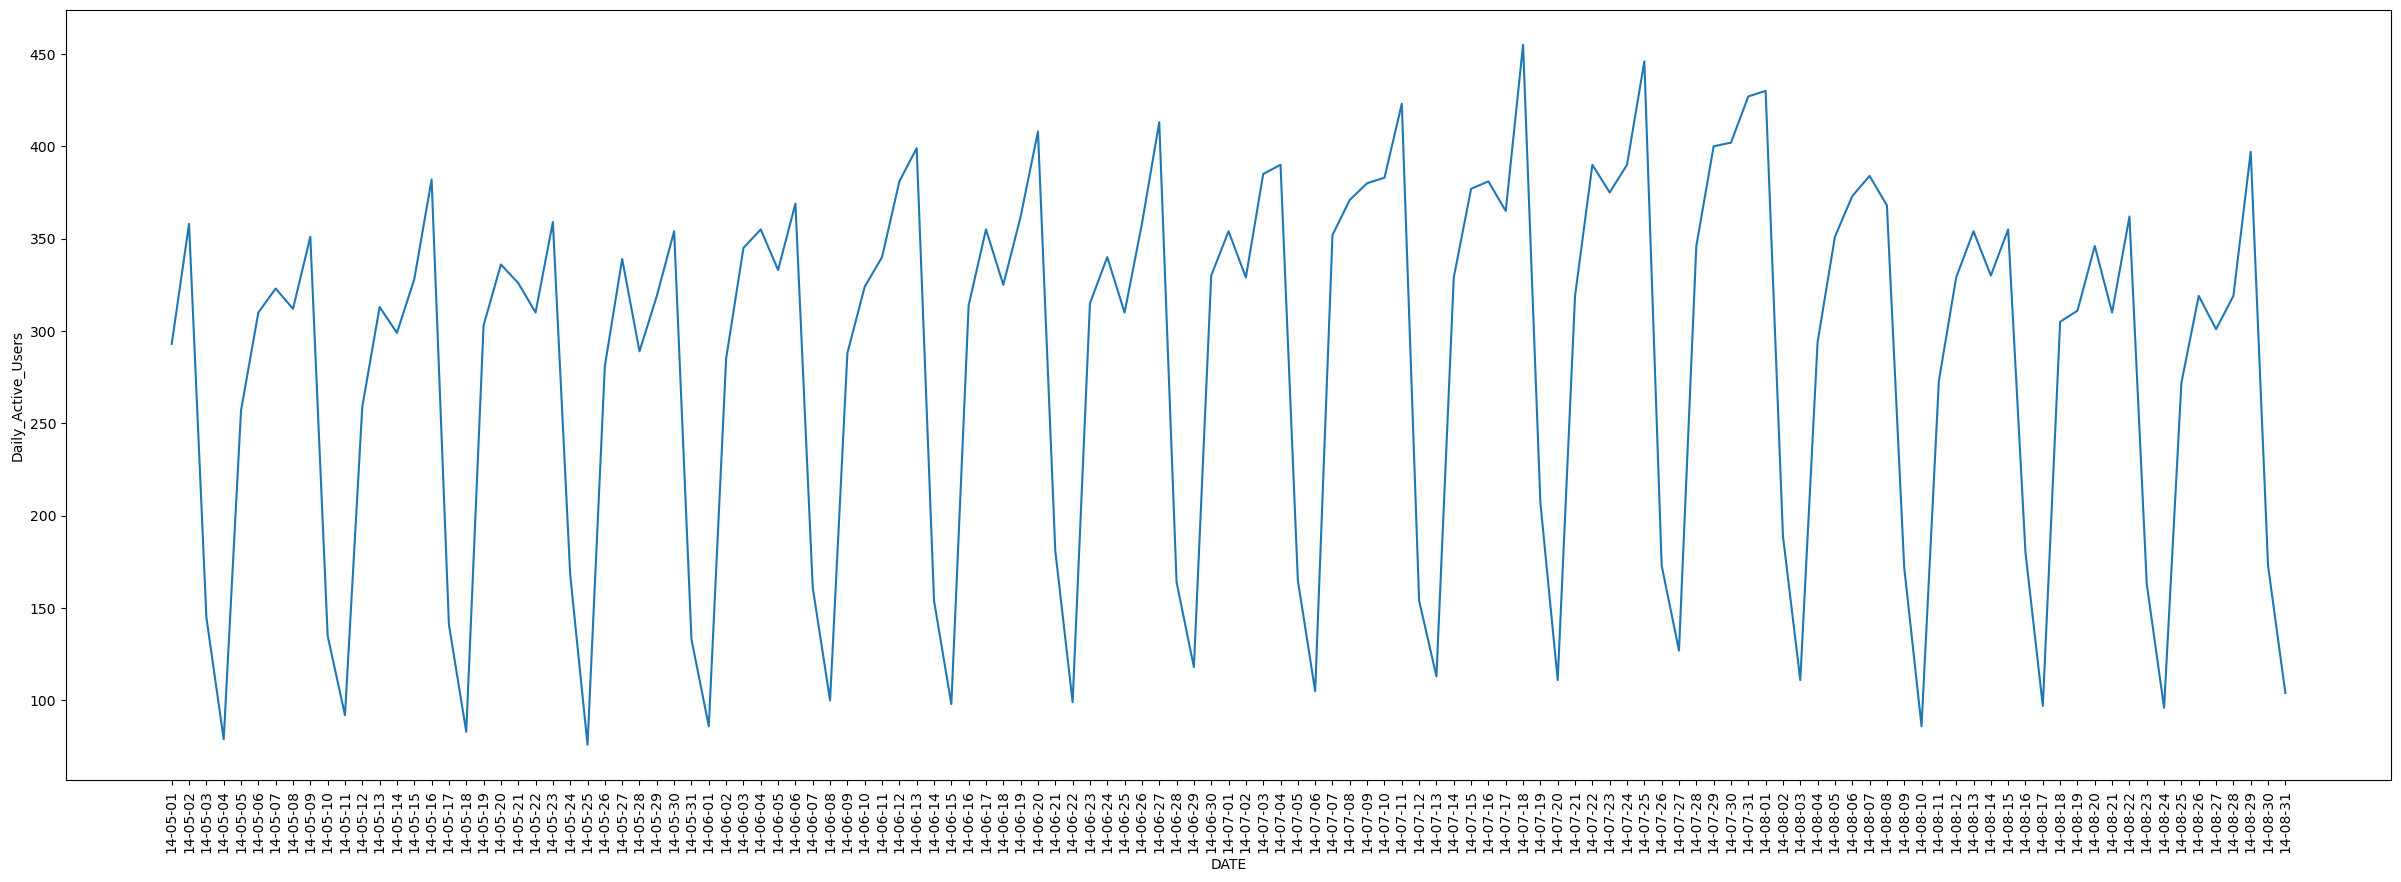

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,10))
sns.lineplot(data=DAU_df,x='DATE', y='Daily_Active_Users')
plt.xticks(rotation=90)
plt.show()

- WAU (Weekly Active Users)

In [202]:
query = " SELECT *, ROUND((WAU-LAG(WAU) OVER())/LAG(WAU) OVER()*100,2) as WAU_GROWTH\
            FROM (SELECT DATE_SUB(DATE_FORMAT(occurred_at, '%y-%m-%d'), INTERVAL WEEKDAY(occurred_at) DAY) start_week,\
                COUNT(DISTINCT user_id) WAU \
                FROM events \
                WHERE event_type = 'engagement' \
            GROUP BY 1 \
            ORDER BY 1) A \
                "

wau_df = pd.read_sql(query, connection)
wau_df


,start_week,WAU,WAU_GROWTH
0,2014-04-28,701,NaN
1,2014-05-05,1054,50.36
2,2014-05-12,1094,3.80
3,2014-05-19,1147,4.84
4,2014-05-26,1113,-2.96
5,2014-06-02,1173,5.39
6,2014-06-09,1219,3.92
7,2014-06-16,1263,3.61
8,2014-06-23,1249,-1.11
9,2014-06-30,1271,1.76


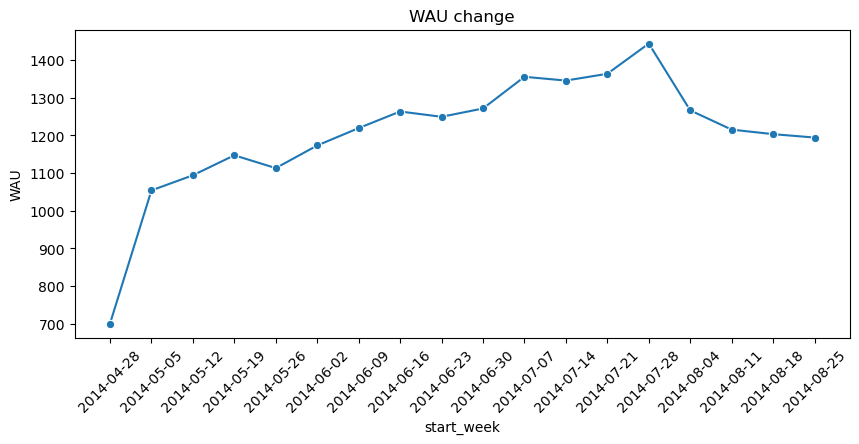

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


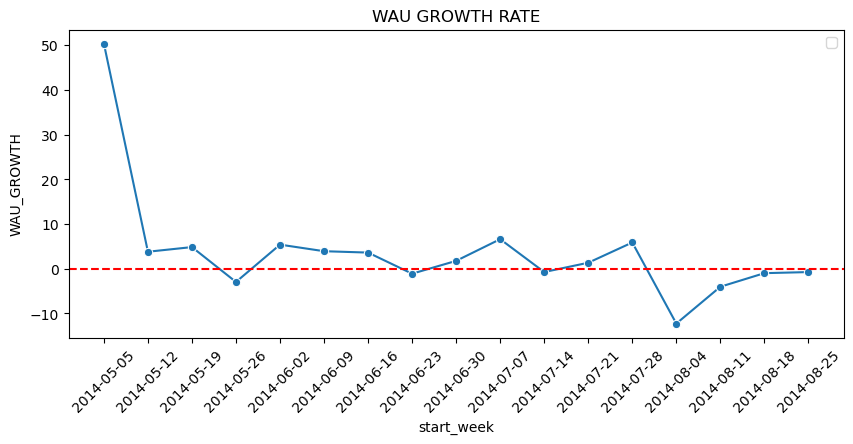

In [203]:
plt.figure(figsize=(10,4))
sns.lineplot(data=wau_df, x='start_week', y='WAU', marker='o')
plt.xticks(rotation=45)
plt.title('WAU change')
plt.show()

plt.figure(figsize=(10,4))
sns.lineplot(data=wau_df,x='start_week', y='WAU_GROWTH', marker='o')
plt.axhline(y=0, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.title('WAU GROWTH RATE')
plt.legend()
plt.show()


- [문제] 2014년 7월 말, 8월 초부터 Weekly Active User 수가 가장 많이 감소했다.
- 해결책을 도출해야 한다.

해결책을 도출하기 위한 분석?
- 가설을 먼저 세워야 한다.
  - 이 현상의 원인이 ~~가 있을 수 있다.
  - 이 원인들 중에서 ~~부터 파악해봐야겠다.

# 가설 & 우선순위

[가설] 아래의 이유때문에 WAU가 감소했을 가능성이 있다.
- Holiday
  - yammers는 사내 페이스북같은 기능이다.
  - 따라서, 특정 국가가 다른 국가보다 훨씬 낮은 engagement를 갖고 있다면, 해당 국가가 공휴일일 수도 있다.
- Broken Feature
  - 어플 기능이 고장나서 사람들이 사용하지 못한 것이 원인일 수도 있다.
  - 서비스 가입 기능 고장, 모바일 앱 고장
- Broken Tracking Code
  - 로그를 수집하는 코드 문제
- Traffic anomalies from bots
  - 대부분 웹사이트에서는 bot의 활동기록이 많다.
  - 제품이나 인프라가 변화해서 봇의 참여가 줄어들 수 있다.
- Traffic shutdown to your site
  - 구글, 네이버 등 internet service providers가 사이트를 차단했을 수도 있다.
- Marketing event
  - 마케팅 이벤트가 순간적으로 engagement를 펌핑했다가 떨어진 것은 아닐까? 예를 들면 superbowl 광고로 유입된 유저들은 서비스 이탈율이 높을 수도 있다.
  - 이럴 땐 marketing department 사람들에게 어떤 빅 마케팅이 있었는지 물어볼 수 있다.
- Bad data
  - QA(Quality Assurance)데이터 (사내 트래킹)를 실제 유저 데이터와 분리하지 않은 상태인데, 만약 이번주부터 QA를 안하기로 했다면 WAU가 떨어질 수도 있다.
- Search Crawler changes
  - 검색 엔진이 우리 서비스를 검색 키워드 몇위에 랭킹 시켜주는지가 서비스 트래픽을 결정할 수 있다 -> 따라서 랭킹로직이 변화되었다면 WAU 변경에 영향을 미칠 수 있다.

이렇게 가설, 원인이 많을 땐 [우선순위]를 반드시 세워야 한다.
1. Experience: 경험이 중요하다. 비슷한 문제에 대한 경험자라면 우선순위를 잘 세울 수 있다.
2. Communication✳️: 관련 부서에게 물어볼 수 있다.
3. Speed: 빠르게 체크할 수 있는 것부터 해야한다. (익숙하거나, 잘 정제되어 있는 데이터라던가, 재활용할 수 있는 쿼리가 있던지..)
4. Dependency: 하나를 확인해보고, 이것과 관련되어 있어서 쉽게 확인할 수 있는 것 순으로 확인해봐라.

# 본격적인 case study
- 지금까지 WAU, DAU를 살펴보았고, 2014-07말 ~ 2014-08초에 급격한 user engagement drop이 발생했다. 
- 왜 이 시기에 user engagement의 drop이 발생하는지를 알아보아야 한다.
- 지금부터 넉넉잡아 `2014-06월 ~ 2014-09`월까지 발생한 로그들을 살펴보겠다.

## 1-1. 신규 가입자 (일별)
- 혹시 신규 가입자가 줄어서 해당 시기에 WAU가 줄진 않았을까?
- 6~9월 사이의 신규가입자 추이를 알아보자.
  - created_at이 6~9월 사이인 계정을 알아보면 된다.

In [204]:
query = " SELECT * FROM users ;"

user_df = pd.read_sql(query, connection)
user_df



,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,None,pending
2,2.0,2013-01-01 10:59:05,51.0,english,None,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active
...,...,...,...,...,...,...
19061,19061.0,2014-08-31 13:21:16,2156.0,chinese,2014-08-31 13:22:50,active
19062,19062.0,2014-08-31 19:21:23,7520.0,spanish,None,pending
19063,19063.0,2014-08-31 07:10:41,72.0,spanish,2014-08-31 07:12:09,active
19064,19064.0,2014-08-31 17:45:18,2.0,english,None,pending


In [205]:
# 2014-06~ 2014-09월 사이에 신규 가입한 유저 수를 살펴보자
query = " SELECT DATE_FORMAT(created_at, '%Y-%m-%d') AS day,\
            COUNT(*) AS all_users,\
            COUNT(CASE WHEN state ='active' THEN user_id ELSE NULL END) AS activated_users \
        FROM users \
        WHERE created_at >= '2014-06-01' AND created_at < '2014-09-01' \
        GROUP BY day \
        ORDER BY day;"


user_df = pd.read_sql(query, connection)
user_df



,day,all_users,activated_users
0,2014-06-01,23,11
1,2014-06-02,69,33
2,2014-06-03,63,29
3,2014-06-04,71,44
4,2014-06-05,76,32
...,...,...,...
87,2014-08-27,90,48
88,2014-08-28,95,50
89,2014-08-29,97,45
90,2014-08-30,26,12


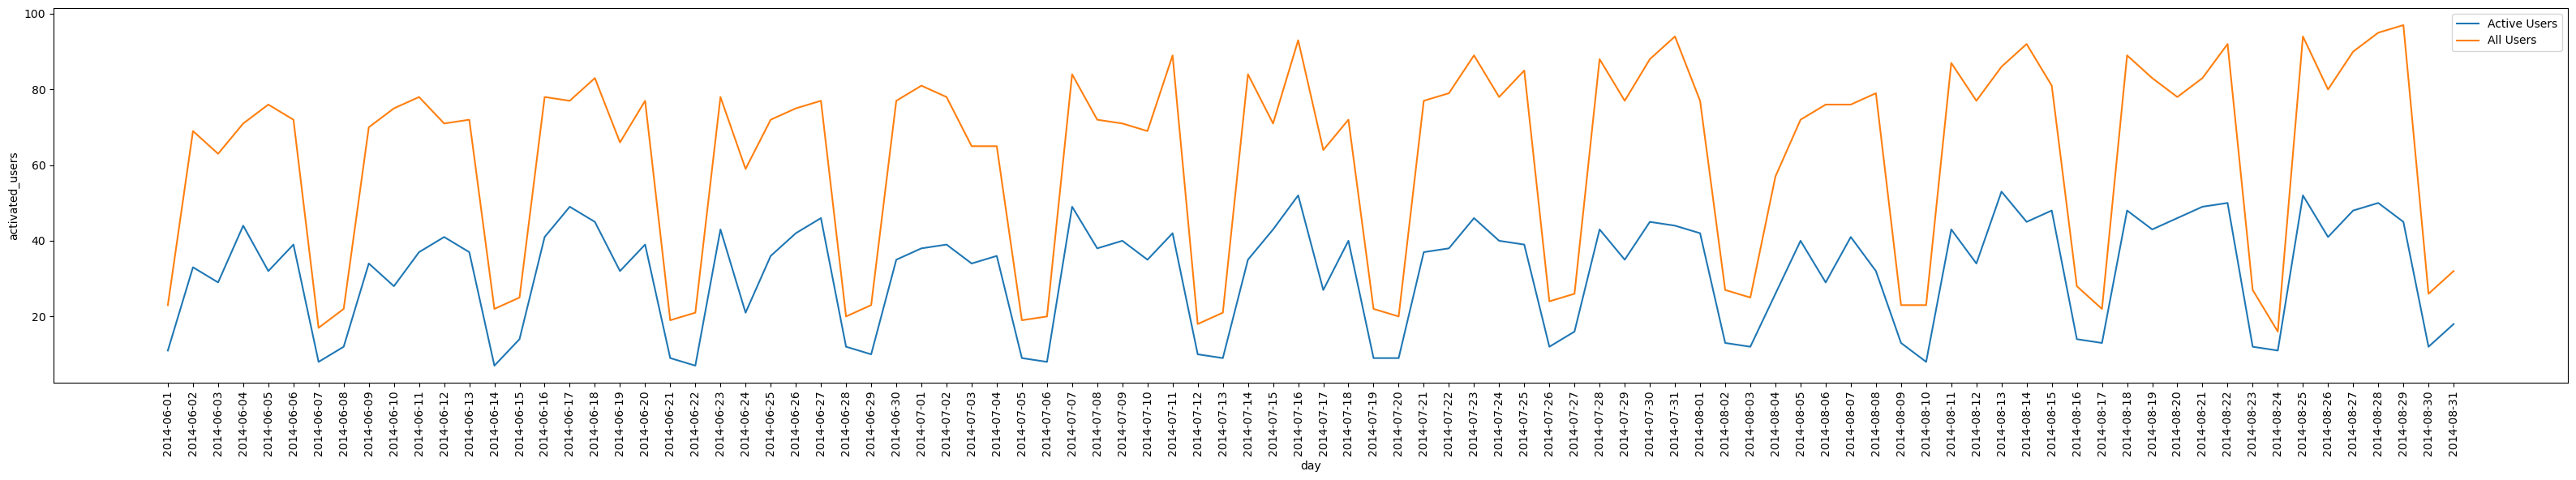

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(40,6))

sns.lineplot(x=user_df.day,y=user_df.activated_users, label='Active Users' )
sns.lineplot(x=user_df.day,y=user_df.all_users, label='All Users' )
plt.legend()
plt.xticks(rotation=90)
plt.show()

- 전 기간에서 신규가입자의 패턴은 비슷하다.
- 7~8월 사이 user engagement의 감소가 신규 가입자의 감소때문은 아닌가??  

## 1-2. 신규 가입자 (주별)

In [234]:
query = " SELECT *, (all_users-LAG(all_users) OVER())/LAG(all_users) OVER()*100 as all_users_growth,  \
                (activated_users-LAG(activated_users) OVER())/LAG(activated_users) OVER()*100 as activated_users_growth \
            FROM \
            (SELECT DATE_SUB(DATE_FORMAT(created_at, '%Y-%m-%d'), INTERVAL WEEKDAY(created_at) DAY) created_week,\
                COUNT(*) as all_users,\
                COUNT( CASE WHEN state='active' THEN user_id ELSE NULL END) as activated_users\
                FROM users \
                WHERE created_at >= '2014-06-01' AND created_at < '2014-09-01' \
                GROUP BY 1 \
                ORDER BY 1) A"


user_week_df = pd.read_sql(query, connection)
user_week_df


,created_week,all_users,activated_users,all_users_growth,activated_users_growth
0,2014-05-26,23,11,NaN,NaN
1,2014-06-02,390,197,1595.6522,1690.9091
2,2014-06-09,413,198,5.8974,0.5076
3,2014-06-16,421,222,1.9370,12.1212
4,2014-06-23,404,210,-4.0380,-5.4054
5,2014-06-30,405,199,0.2475,-5.2381
6,2014-07-07,424,223,4.6914,12.0603
7,2014-07-14,426,215,0.4717,-3.5874
8,2014-07-21,458,228,7.5117,6.0465
9,2014-07-28,476,234,3.9301,2.6316


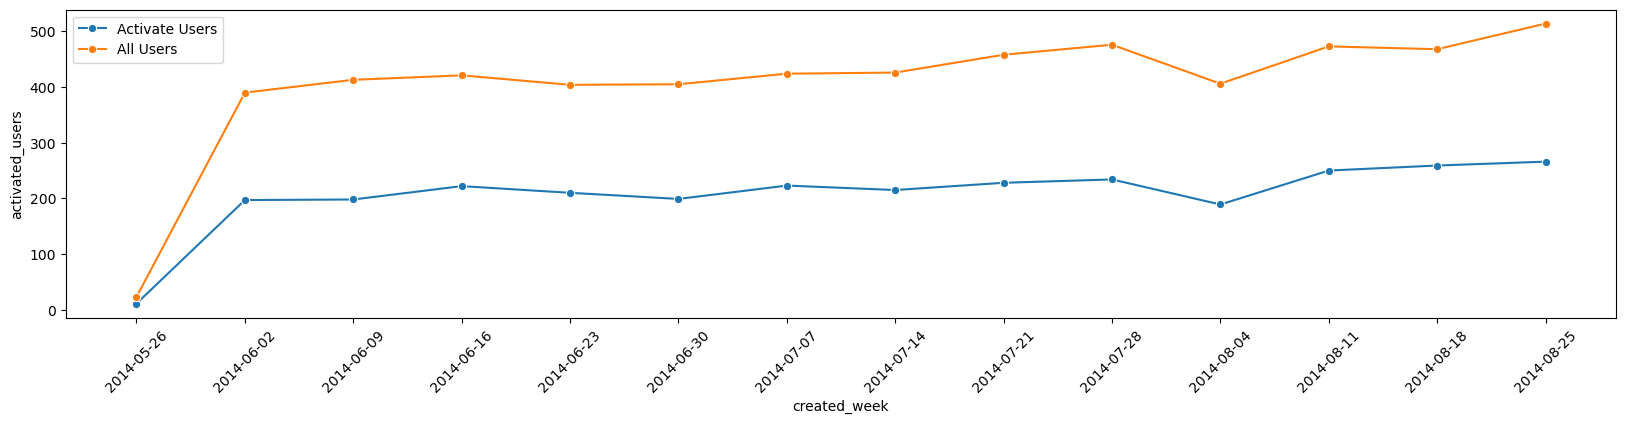

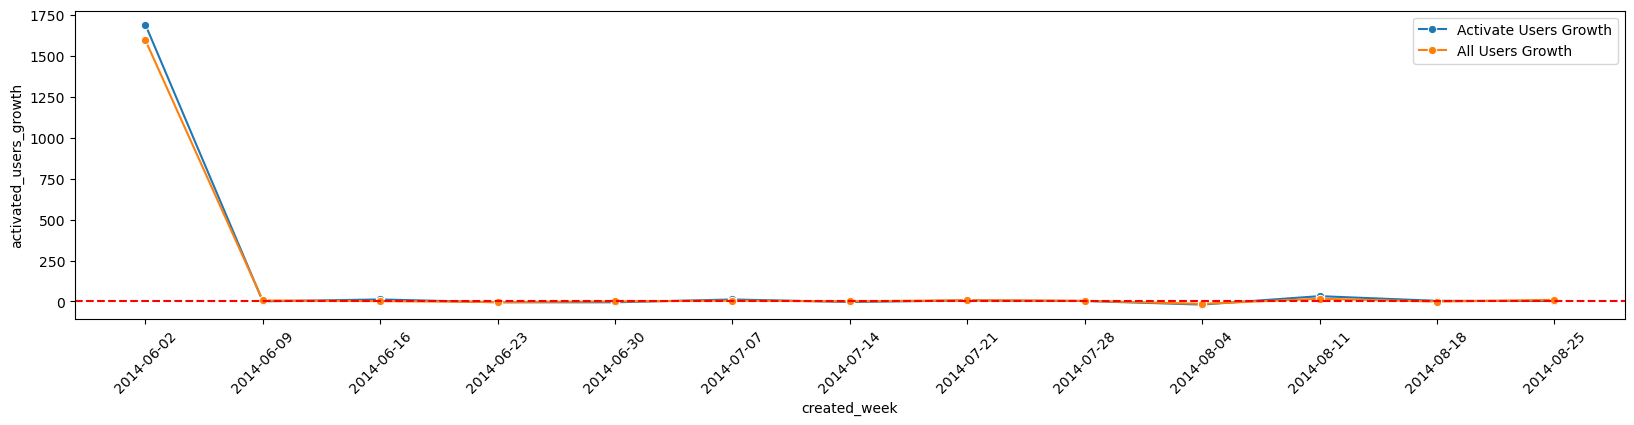

In [250]:
plt.figure(figsize=(20,4))

sns.lineplot(x=user_week_df.created_week,y=user_week_df.activated_users, marker='o', label='Activate Users')
sns.lineplot(x=user_week_df.created_week,y=user_week_df.all_users, marker='o', label = 'All Users')
plt.legend()
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(20,4))

sns.lineplot(x=user_week_df.created_week,y=user_week_df.activated_users_growth, marker='o', label='Activate Users Growth')
sns.lineplot(x=user_week_df.created_week,y=user_week_df.all_users_growth, marker='o', label = 'All Users Growth')
plt.axhline(y=0, color='red',linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.show()

- 주별로 신규 가입자를 분석해보니, 7~8월에 신규 유저 감소가 보인다.
- 신규유저가 감소한 원인은 무엇일까? 신규 가입을 확대할 수 있는 마케팅을 펼쳐야 할 것.

## 2. 코호트별 WAU 분석
- 기존 사용자를 분석해보자.
- `가입 시기`에 따라 user를 나눠보자.
- 예) 1.1~1.15일에 가입한 user를 group1로, 1.16~1.30에 가입한 user를 group2로 보는 것.


- `2014.06 ~ 2014.09` 사이에 활동한 기존 사용자를 어떻게 정의할까?
  - state = 'active' (계정이 활성화 된 user)
  - event_type = 'engagement' (활동을 하고 있는 user)
  - event_name = 'login' (로그인을 한 유저)

### 코호트 분석
- cohort: group of users sharing a common characteristic.
  - cohort can be a group of users who signed up in the same month or made the first purchase in t he same week.
- cohort analysis: analyzing the behavior group of users over time.


In [340]:
### 1. user age 구하기, 주별로 묶기
query = " SELECT event_happened_week, week_cnt, COUNT(DISTINCT user_id) as user_cnt\
            FROM (SELECT  u.user_id,\
                DATE_SUB(DATE_FORMAT(e.occurred_at, '%Y-%m-%d'), INTERVAL WEEKDAY(e.occurred_at) DAY) event_happened_week,\
                CASE WHEN DATEDIFF('2014-09-01', u.created_at) >=70 THEN '10+ weeks'\
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 63 AND 69 THEN '9 weeks' \
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 56 AND 62 THEN '8 weeks' \
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 49 AND 55 THEN '7 weeks' \
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 42 AND 48 THEN '6 weeks' \
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 35 AND 41 THEN '5 weeks' \
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 28 AND 34 THEN '4 weeks' \
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 21 AND 27 THEN '3 weeks' \
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 14 AND 20 THEN '2 weeks' \
                    WHEN DATEDIFF('2014-09-01', u.created_at) BETWEEN 7 AND 13 THEN '1 week' \
                ELSE 'less than a week' \
                END AS 'week_cnt'\
                FROM users u \
                JOIN events e \
                ON u.user_id = e.user_id \
                    AND e.event_type = 'engagement' \
                    AND  e.event_name = 'login' \
                    AND e.occurred_at >= '2014-05-01' AND e.occurred_at < '2014-09-01' \
                WHERE u.state = 'active') A\
            GROUP BY event_happened_week, week_cnt \
            ORDER BY event_happened_week"

cohort_df = pd.read_sql(query, connection)
cohort_df

,event_happened_week,week_cnt,user_cnt
0,2014-04-28,10+ weeks,701
1,2014-05-05,10+ weeks,1054
2,2014-05-12,10+ weeks,1094
3,2014-05-19,10+ weeks,1147
4,2014-05-26,10+ weeks,1113
...,...,...,...
68,2014-08-25,6 weeks,24
69,2014-08-25,7 weeks,19
70,2014-08-25,8 weeks,19
71,2014-08-25,9 weeks,17


In [341]:
# 'variable' 열을 행 인덱스로, 'value' 열을 새로운 열로 변환
pivot_df = cohort_df.pivot(index='event_happened_week', columns='week_cnt', values='user_cnt')
pivot_df = pivot_df[[ '10+ weeks', '9 weeks','8 weeks','7 weeks','6 weeks','5 weeks','4 weeks','3 weeks', '2 weeks','1 week','less than a week']]

# 결과 확인
pivot_df


week_cnt,10+ weeks,9 weeks,8 weeks,7 weeks,6 weeks,5 weeks,4 weeks,3 weeks,2 weeks,1 week,less than a week
event_happened_week,,,,,,,,,,,
2014-04-28,701.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-05,1054.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-12,1094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-19,1147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-26,1113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-02,1173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-09,1219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-16,1262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-23,1082.0,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


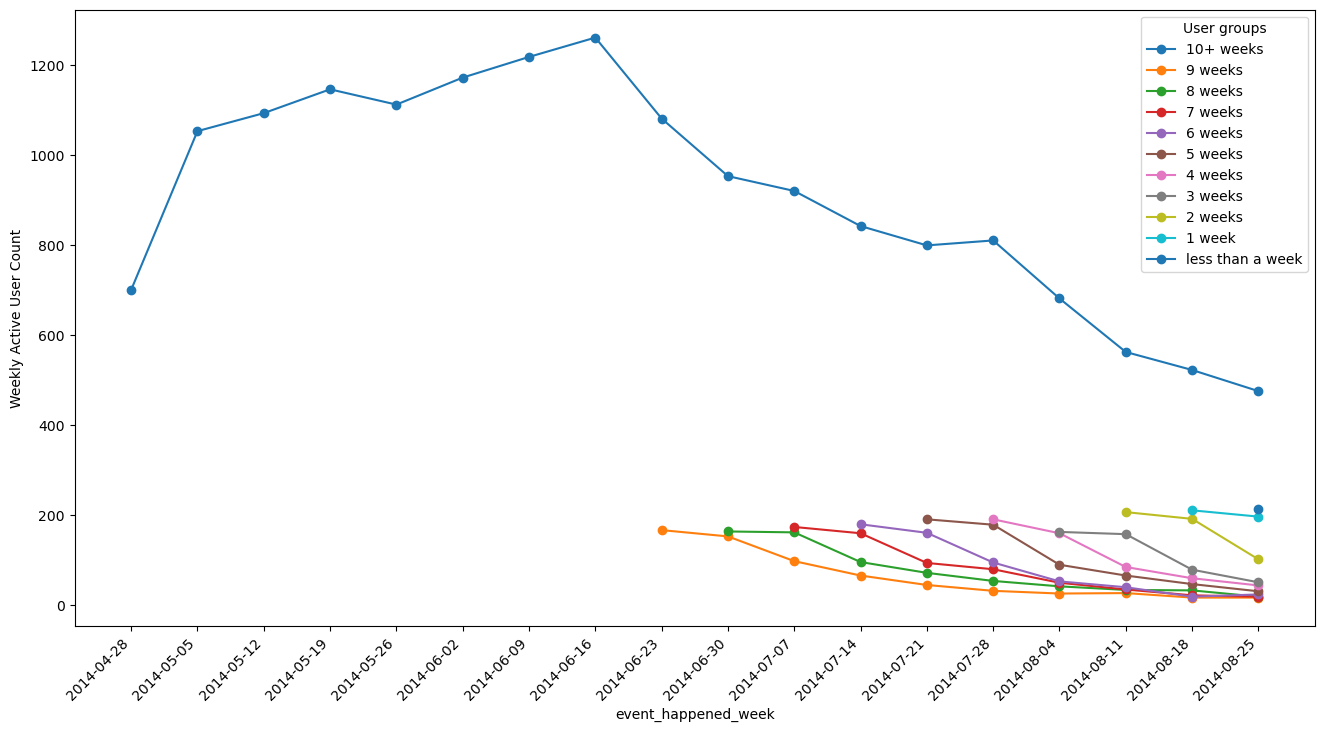

In [342]:
plt.figure(figsize=(16,8))
plt.plot(pivot_df, label = pivot_df.columns, marker = 'o')
plt.xlabel('event_happened_week')
plt.ylabel('Weekly Active User Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='User groups')
plt.show()

- 가입으로부터 시간이 지날 수록 Active User가 감소하는 것은 Retention 차트의 전형적인 패턴이다.
  - less than a week ~ 9 weeks까지의 그룹은 일반적인 retention 차트의 특성을 보인다.

- 그러나, 10+ weeks를 주목해야 한다.
  - 10+ weeks 그룹: 10주 이전에 가입한 그룹. 여기에는 10주 전, 11주 전, 12주 전..등등 사용자 모두 포함
  - 따라서 2014-06월 중순까지 활동이 꾸준히 상승 (가입자가 늘고있기 때문에)
  - 이들은 2016-06-15일부터활동이 줄어든다. (일반적인 패턴)
  - 근데 2014-08월 이전까지 다시 사용량이 상승하다가 8월 이후 급격하게 감소한다.

- 결론: older user들로부터 이러한 WAU 감소가 나타나는 듯 하다.
  - 즉, WAU의 감소가 마케팅 트래픽으로 인한 spike나 서치엔진의 랭킹 변화나 사이트 차단과 같은 new traffic에 영향을 주는 요소들과는 관계가 없다는 것이다.
  - 이젠 다양한 device type을 살펴보자.

## 3. 디바이스별 WAU

In [351]:
query = " SELECT device_type, event_happened_week, COUNT(DISTINCT user_id) as user_cnt\
          FROM (SELECT e.user_id, \
              DATE_SUB(DATE_FORMAT(e.occurred_at, '%Y-%m-%d'), INTERVAL WEEKDAY(e.occurred_at) DAY) event_happened_week, \
              CASE \
                WHEN device IN ('macbook pro', 'lenovo thinkpad', 'macbook air', 'dell inspiron notebook', 'asus chromebook', 'dell inspiron desktop', 'acer aspire notebook', 'hp pavilion desktop', 'acer aspire desktop', 'mac mini') THEN 'computer' \
                WHEN device IN ('iphone 5', 'samsung galaxy s4', 'nexus 5', 'iphone 5s', 'iphone 4s', 'nokia lumia 635', 'htc one', 'samsung galaxy note', 'amazon fire phone') THEN 'phone' \
                WHEN device IN ('ipad air', 'nexus 7', 'ipad mini', 'nexus 10', 'kindle fire', 'windows surface', 'samsung galaxy tablet','samsumg galaxy tablet') THEN 'tablet'\
                ELSE 'NONE'\
              END AS 'device_type'\
            FROM events e JOIN users u ON e.user_id = u.user_id\
            AND e.event_type = 'engagement' AND e.event_name = 'login'\
              AND e.occurred_at >= '2014-05-01' AND e.occurred_at < '2014-09-01' \
                      WHERE u.state = 'active') A\
            GROUP BY device_type, event_happened_week ;"
test_df = pd.read_sql( query, connection)
test_df

,device_type,event_happened_week,user_cnt
0,computer,2014-04-28,415
1,computer,2014-05-05,712
2,computer,2014-05-12,715
3,computer,2014-05-19,758
4,computer,2014-05-26,716
5,computer,2014-06-02,791
6,computer,2014-06-09,798
7,computer,2014-06-16,812
8,computer,2014-06-23,834
9,computer,2014-06-30,805


In [357]:
test_pivot_df = test_df.pivot(index='event_happened_week', columns='device_type', values='user_cnt')
test_pivot_df
# test_group_df

device_type,computer,phone,tablet
event_happened_week,,,
2014-04-28,415,281,111
2014-05-05,712,461,187
2014-05-12,715,481,197
2014-05-19,758,526,190
2014-05-26,716,500,182
2014-06-02,791,505,208
2014-06-09,798,545,209
2014-06-16,812,541,238
2014-06-23,834,526,222


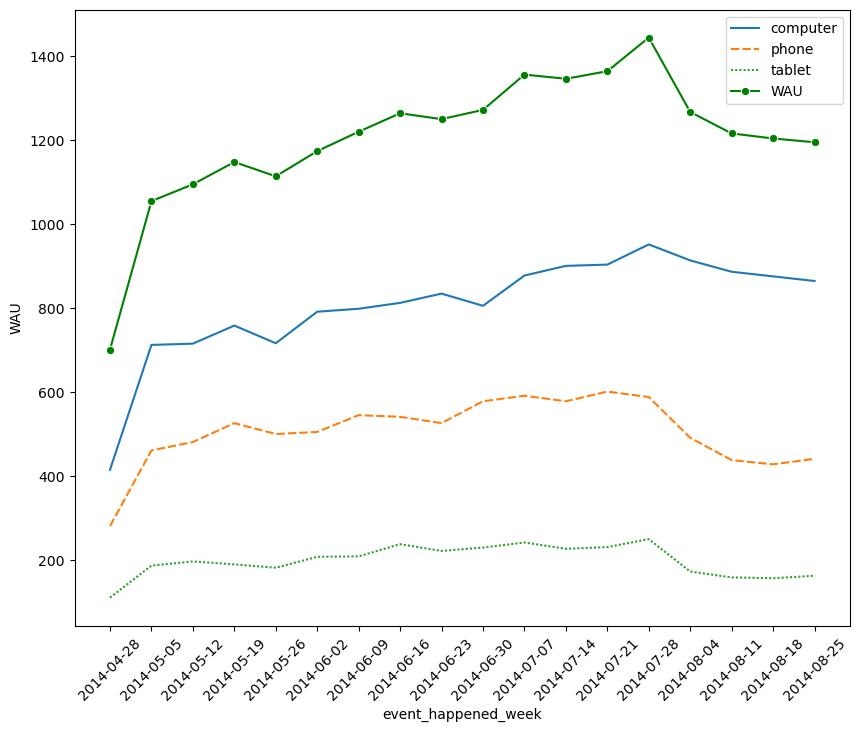

In [362]:
plt.figure(figsize=(10,8))
sns.lineplot(data=test_pivot_df)
sns.lineplot(data=wau_df, x='start_week', y='WAU', marker='o', color='green', label='WAU')

plt.xticks(rotation=45)
plt.show()

In [369]:
growth_df = pd.DataFrame()
growth_df['computer_growth'] = (test_pivot_df['computer']-test_pivot_df['computer'].shift(1))/test_pivot_df['computer'].shift(1)*100
growth_df['phone_growth'] = (test_pivot_df['phone']-test_pivot_df['phone'].shift(1))/test_pivot_df['phone'].shift(1)*100
growth_df['tablet_growth'] = (test_pivot_df['tablet']-test_pivot_df['tablet'].shift(1))/test_pivot_df['tablet'].shift(1)*100
growth_df

,computer_growth,phone_growth,tablet_growth
event_happened_week,,,
2014-04-28,NaN,NaN,NaN
2014-05-05,71.566265,64.056940,68.468468
2014-05-12,0.421348,4.338395,5.347594
2014-05-19,6.013986,9.355509,-3.553299
2014-05-26,-5.540897,-4.942966,-4.210526
2014-06-02,10.474860,1.000000,14.285714
2014-06-09,0.884956,7.920792,0.480769
2014-06-16,1.754386,-0.733945,13.875598
2014-06-23,2.709360,-2.772643,-6.722689


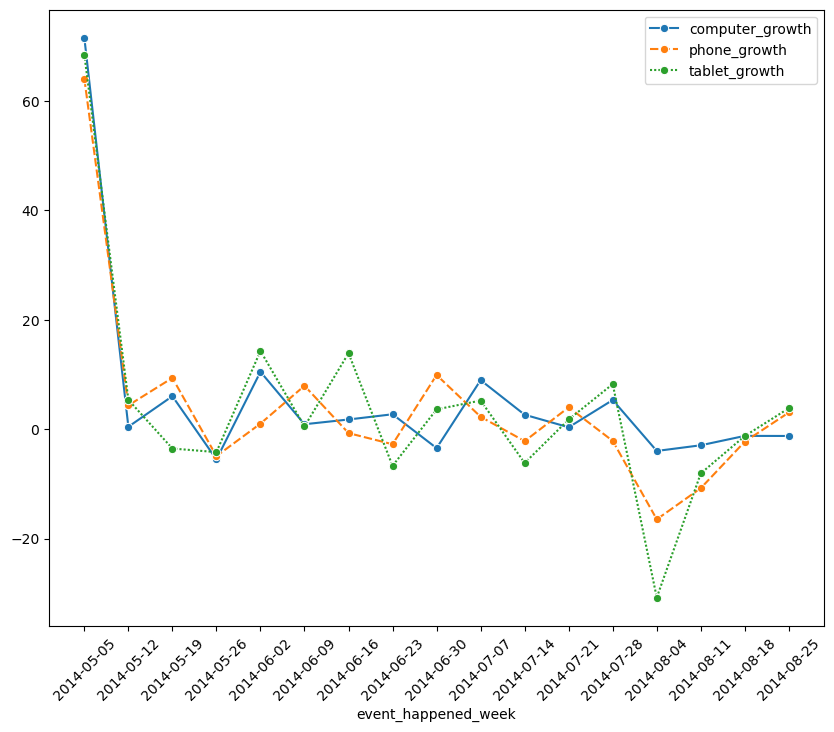

In [372]:
plt.figure(figsize=(10,8))
sns.lineplot(data=growth_df, marker='o')

plt.xticks(rotation=45)
plt.show()

- 7~8월에 computer, phone, tablet 모두 사용량이 감소하고 있으나, `phone`, `tablet` 에서 사용 user의 감소폭이 크다.
- 모바일 앱에 문제가 생겼을 수도 있다. 관련 부서에 물어봐야 한다.

## 4. email 분석
- 2번 분석에서 old user의 사용량 감소가 2014-08월 WAU 감소의 원인이었다.
- old user는 마케팅보다는 email newsletter로 들어올 가능성이 크다.
- 따라서 email 유입원에 따라 분석을 진행하겠다.

In [383]:
query = " SELECT type, event_happened_week, COUNT(DISTINCT user_id) as user_cnt \
            FROM (SELECT *, CASE WHEN action = 'sent_weekly_digest' THEN 'weekly_emails' \
                        WHEN action = 'email_open' THEN 'email_opens' \
                        WHEN action = 'email_clickthrough' THEN 'email_clickthrough' \
                        WHEN action  = 'sent_reengagement_email' THEN 'reengagement_emails' \
                    ELSE 'NONE' END AS type, \
                DATE_SUB(DATE_FORMAT(occurred_at, '%Y-%m-%d') , INTERVAL WEEKDAY(occurred_at) DAY ) 'event_happened_week'\
            FROM emails)A \
            GROUP BY type, event_happened_week"

df = pd.read_sql(query,connection)
df

,type,event_happened_week,user_cnt
0,email_clickthrough,2014-04-28,187
1,email_clickthrough,2014-05-05,431
2,email_clickthrough,2014-05-12,478
3,email_clickthrough,2014-05-19,495
4,email_clickthrough,2014-05-26,447
...,...,...,...
67,weekly_emails,2014-07-28,3706
68,weekly_emails,2014-08-04,3793
69,weekly_emails,2014-08-11,3897
70,weekly_emails,2014-08-18,4012


In [385]:
pivot_df = df.pivot(index='event_happened_week', columns='type', values='user_cnt')
pivot_df

type,email_clickthrough,email_opens,reengagement_emails,weekly_emails
event_happened_week,,,,
2014-04-28,187,332,98,908
2014-05-05,431,910,164,2602
2014-05-12,478,961,175,2665
2014-05-19,495,984,179,2733
2014-05-26,447,1008,179,2822
2014-06-02,483,972,199,2911
2014-06-09,527,1058,190,3003
2014-06-16,558,1144,234,3105
2014-06-23,517,1080,187,3207


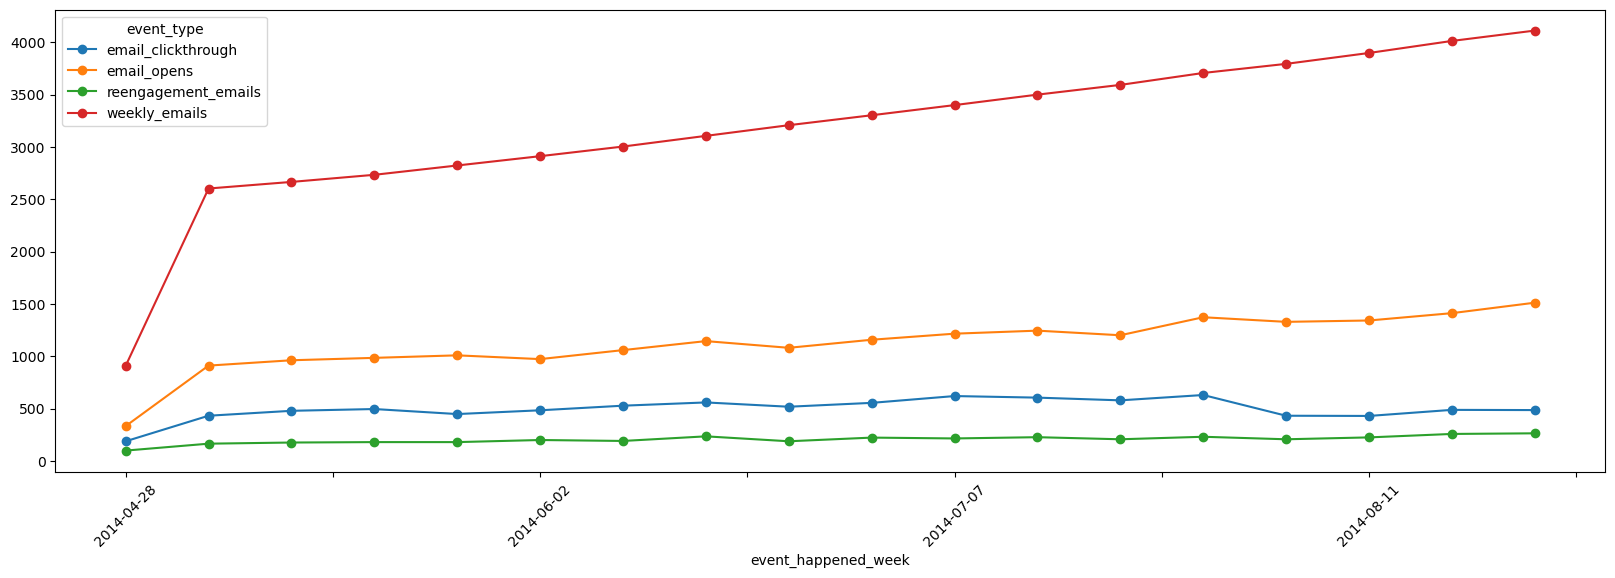

In [388]:
pivot_df.plot(figsize=(20,6), marker = 'o')
plt.legend(title='event_type')
plt.xticks(rotation=45)
plt.show()

- 7월말 ~ 8월초에 email_clickthrough가 감소했다.
- 사용자가 이메일을 수신하고 open하는 것까지는 문제가 없다. 그러나, 이메일 내부 링크를 통해 서비스에 접속한 유저가 감소했다.
- 이메일 내부 링크가 작동을 안할 수도 있다.

## 결론
2014-07말~ 2014-08초에 WAU가 감소한 이유는 아래와 같다.
- 1. 비교적 최근 가입한 user보단 old users 사이에서 사용량이 감소한다.
- 2. device 중 mobile(phone, tablet) user의 사용량이 감소했다.
- 3. digest email 내의 링크 클릭량이 감소했다. 링크에 문제가 있을 수도 있다.
- 